In [8]:
import numpy as np
import seaborn as sns
import pandas as pd
import xarray as xr
import utils
import pickle
import scipy.stats as stats
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
utils.set_plot_configs(plt, fsize=8)

In [3]:
results_dir = utils.get_path('results')
datasets_dir = utils.get_path('datasets')

In [4]:
with open(results_dir+"/fair/historical_zec.pkl", "rb") as file:                                                                            
    f = pickle.load(file)    

TCR = f.ebms.tcr
ECS = f.ebms.ecs

Fze = f.forcing_sum.sel(timebounds=2023).isel(scenario=0)
Ff = f.forcing_sum.sel(timebounds=3000).isel(scenario=0)

Fze.name = "F$_\\text{ze}$"
Ff.name = "F$_\\text{f}$"
TCR.name = "TCR"
ECS.name = "ECS"

dataset = xr.merge([TCR,ECS,Fze,Ff], compat="override")
dataset = dataset.drop_vars(["scenario","timebounds"])
data = dataset.to_pandas()

/tmp/ipykernel_153136/2512118233.py:16: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  dataset = dataset.drop(["scenario","timebounds"])


In [5]:
ds = xr.open_mfdataset(datasets_dir+"/forster_2023_ERF_ensemble.nc")
ds_last = ds.isel(time=-1)
ds_last = ds_last.drop_vars(["volcanic","solar"])
F_anthro_2022 = ds_last.to_array().sum("variable").load()

/tmp/ipykernel_153136/216376733.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_last = ds_last.drop(["volcanic","solar"])


In [6]:
F_anthro_2022_kde = stats.gaussian_kde(F_anthro_2022)

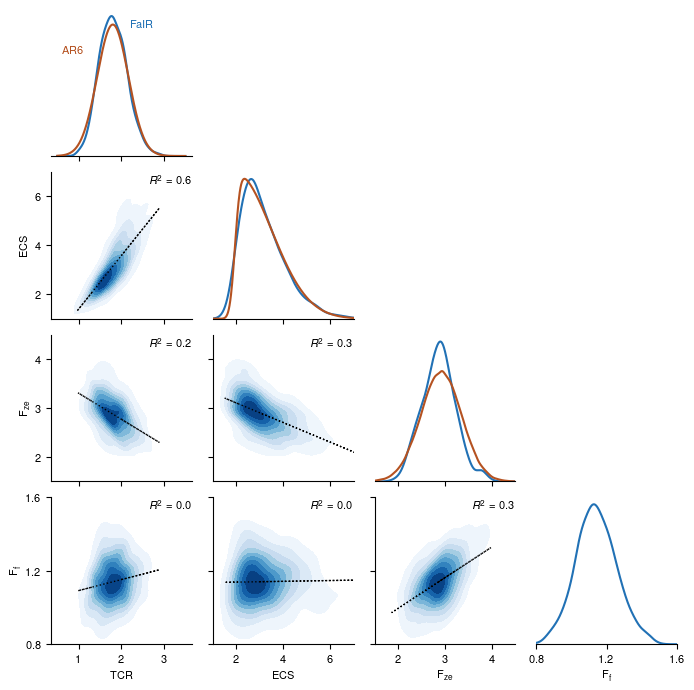

In [9]:
blue = "#2171b5"
orange = "#b55221"
x_ecs = np.linspace(0, 8, 500)  # Range for ECS
x_tcr = np.linspace(.5, 3.5, 500)  # Range for TCR

NINETY_TO_ONESIGMA = stats.norm.ppf(0.95)

def opt(x, q05_desired, q50_desired, q95_desired):
    "x is (a, loc, scale) in that order."
    q05, q50, q95 = stats.skewnorm.ppf(
        (0.05, 0.50, 0.95), x[0], loc=x[1], scale=x[2]
    )
    return (q05 - q05_desired, q50 - q50_desired, q95 - q95_desired)

ecs_params = optimize.root(opt, [1, 1, 1], args=(2, 3, 5)).x

# Define TCR distribution parameters (normal)
tcr_mean = 1.8
tcr_std = 0.6 / NINETY_TO_ONESIGMA

# Compute PDFs
ecs_pdf = stats.skewnorm.pdf(x_ecs, ecs_params[0], loc=ecs_params[1], scale=ecs_params[2])
tcr_pdf = stats.norm.pdf(x_tcr, loc=tcr_mean, scale=tcr_std)

def density_kde(x, y, **kwargs):
    ax = plt.gca()
    sns.kdeplot(x=x, y=y, fill=True, cmap="Blues", ax=ax)
    slope, intercept, r_value, _, _ = linregress(x, y)
    ax.plot(x, slope * np.array(x) + intercept, color="black", lw=1, linestyle="dotted")
    # Display R^2 value
    r2 = r_value**2
    ax.text(0.7, 0.98, f"$R^2={r2:.1f}$", transform=ax.transAxes, fontsize=8,
            va='top', color="black")

def plot_kde(data, x, ax):
    kde = stats.gaussian_kde(data)
    y = kde.pdf(x)
    ax.plot(x,y,color=blue, lw=1.5, zorder=0)
    
def diags(data, **kwargs):
    ax = plt.gca()
    if data.name == "ECS":
        plot_kde(data, x_ecs, ax)
        ax.plot(x_ecs, ecs_pdf, color=orange, lw=1.5,zorder=2)
        
    if data.name == "TCR":
        plot_kde(data, x_tcr, ax)
        ax.plot(x_tcr, tcr_pdf, color=orange, lw=1.5,zorder=2)

    if data.name == "F$_\\text{ze}$":
        x_Fze = np.linspace(1,4.5,int(1e3))
        plot_kde(data, x_Fze, ax)
        ax.plot(x_Fze, F_anthro_2022_kde.pdf(x_Fze), color=orange, 
                lw=1.5, zorder=2)

    if data.name == "F$_\\text{f}$":
        x_Ff = np.linspace(.6,1.7,int(1e3))
        plot_kde(data, x_Ff, ax)
        
    ax.set_ylim([0,None])

aspect_ratio = 1  
width = 7          
height = width * aspect_ratio

g = sns.PairGrid(data, corner=True, height=height / len(data.columns), diag_sharey=False)
g.map_lower(density_kde)
g.map_diag(diags)

ax = g.axes[0,0]
ax.text(.08, .7, "AR6", color=orange, transform=ax.transAxes)
ax.text(.56, .88, "FaIR", color=blue, transform=ax.transAxes)

# Adjust axis limits and ticks
limits = [[1, 2, 3], [2, 4, 6], [2, 3, 4], [0.8, 1.2, 1.6]]
for i, lim in zip(np.arange(len(data.columns)), limits):
    g.axes[i, i].set_xticks(lim)
    g.axes[i, i].set_yticks(lim)

g.axes[1,0].set_ylim([1,7])
g.axes[3,1].set_xlim([1,7])

g.axes[2,0].set_ylim([1.5,4.5])
g.axes[3,2].set_xlim([1.5,4.5])

g.axes[3,0].set_ylim([.8, 1.6])
g.axes[3,3].set_xlim([.8, 1.6])

g.savefig(results_dir+"/figures/sfig_cov.pdf")